In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

import tensorflow as tf
tf.enable_eager_execution()
tf.executing_eagerly()

True

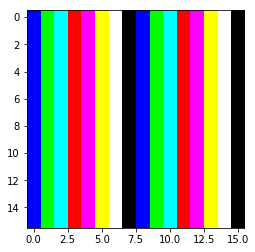

In [2]:
import sys; sys.path.append(str(Path.home()))

N = 16
def image_gen():
    colors = [np.array([int(x) for x in f'{b:03b}']) for b in range(8)]
    # print(colors)
    n, d = N, 1
    image = np.zeros((5, n, n, 3))
    for y in range(n):
        for x in range(n):
            image[0, y, x#(x+2*y)%n
                 ] = colors[(x+1) % 8] * 255
    return image.astype(np.uint8)

def rescale(img, m=32):
    b, h, w, c = np.array(img.shape) 
    res = np.empty((b, h*m, w*m, c))
    for k in range(b):
        for i in range(h):
            for j in range(w):
                res[k, i*m:i*m+m, j*m:j*m+m] = img[k, i, j]
    return res

img = tf.convert_to_tensor(rescale(image_gen(), m=1).astype(np.float32))
# img = tf.expand_dims(img, 0)
plt.imshow(img[0]/255)

In [3]:
arr = tf.convert_to_tensor((np.random.rand(*img.shape[:3], 1)*2).astype(np.float32))
arr[0,...,0].numpy()

array([[1.1480393e+00, 6.9135392e-01, 1.0562427e+00, 1.6109462e+00,
        4.3121675e-01, 1.3203492e+00, 6.2051952e-01, 1.6347953e+00,
        9.2409968e-01, 6.8821132e-01, 1.7827611e+00, 1.0018167e+00,
        7.6955724e-01, 9.7148287e-01, 1.8162906e+00, 1.3642888e+00],
       [1.3656815e+00, 1.3133861e-01, 5.5027145e-01, 3.4851652e-01,
        8.9841491e-01, 1.8227767e+00, 1.6781632e+00, 1.6110454e+00,
        4.0083545e-01, 1.5560089e+00, 1.2931980e+00, 1.5705398e+00,
        1.5610127e+00, 3.3633819e-01, 1.9015585e+00, 4.1953459e-01],
       [9.0997612e-01, 6.0378814e-01, 1.2819012e+00, 1.4275315e-01,
        7.7923691e-01, 1.2259659e-03, 4.4117853e-01, 8.9809525e-01,
        6.6493857e-01, 1.8245572e+00, 1.1023884e+00, 6.7473106e-02,
        1.2750434e+00, 1.2493479e+00, 1.5433123e+00, 4.0128124e-01],
       [1.0169502e+00, 1.3675882e+00, 1.4071866e+00, 1.5062922e+00,
        1.1013454e+00, 1.5085236e+00, 7.7826089e-01, 1.3687292e+00,
        1.1880808e+00, 1.6660675e+00, 8.02638

(5, 16, 16, 3) (5, 16, 16, 1)
<dtype: 'float32'> <dtype: 'float32'>
int_floor


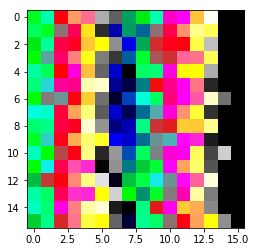

In [4]:
from dense_image_warp import dense_image_warp
print(img.shape, arr.shape)
print(img.dtype, arr.dtype)
warped0 = dense_image_warp(img, arr)
plt.imshow(warped0[0]/255)

int_floor


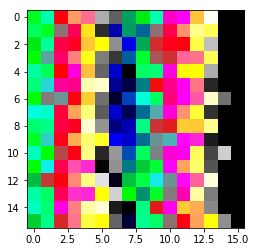

In [5]:
sys.path.append('/home/marek/emfnet')
from bilinear_sampler import linear_sampler
warped00 = linear_sampler(img, arr)
plt.imshow(warped00[0]/255)

W: (5, 16, 16) (1, 1, 16)
H: (5, 16, 16) (1, 1, 16)
B: (5, 16, 16) (1, 1, 16)
@@@ [[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15]
 [ 256  257  258  259  260  261  262  263  264  265  266  267  268  269
   270  271]
 [ 512  513  514  515  516  517  518  519  520  521  522  523  524  525
   526  527]
 [ 768  769  770  771  772  773  774  775  776  777  778  779  780  781
   782  783]
 [1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037
  1038 1039]]
(1280, 3) (1280, 1) (1280, 3)
<dtype: 'float32'> <dtype: 'int32'> <dtype: 'float32'>
W: (5, 16, 16) (1, 1, 16)
H: (5, 16, 16) (1, 1, 16)
B: (5, 16, 16) (1, 1, 16)
@@@ [[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15]
 [ 256  257  258  259  260  261  262  263  264  265  266  267  268  269
   270  271]
 [ 512  513  514  515  516  517  518  519  520  521  522  523  524  525
   526  527]
 [ 768  769  770  771  772  773  774  775  776  777  778  779  780  78

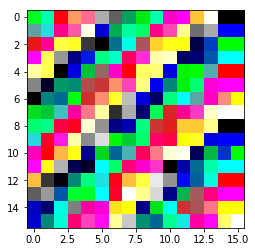

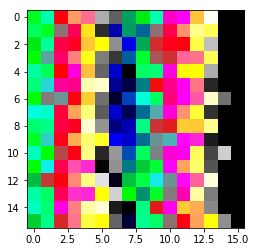

In [6]:
def _impl_our_linear_warp(inputs, indices, indexed_inputs, deltas, name):
#     print(indices.numpy())
    def simple_corr(inputs, int_indices, indexed_inputs):
#         print(int_indices.numpy())
        b, h, w, c = inputs.shape
        
#         row = 0
#         print(int_indices[0,row,:,0].numpy())
#         bak = int_indices.numpy()
#         int_indices = int_indices + tf.reshape(tf.range(w), [1, 1, w, 1])
#         print(int_indices[0,row,:,0].numpy())
#         print('D: ', (int_indices.numpy()-bak)[0,row,:,0])
        
        int_indices = tf.reshape(int_indices, [b, h, w])
        
        width_offsets  = tf.reshape(tf.range(w),     [1, 1, w])
        height_offsets = tf.reshape(tf.range(h)*w,   [1, h, 1])
        batch_offsets  = tf.reshape(tf.range(b)*h*w, [b, 1, 1])
        
        
#         int_indices = tf.reshape(int_indices, [b, h, w])
        
        flatten_indices = tf.clip_by_value(width_offsets + int_indices, 0, w-1)
        print('W:', flatten_indices.shape, width_offsets.shape)
    
    
        flatten_indices = height_offsets + flatten_indices
        print('H:', flatten_indices.shape, width_offsets.shape)
        
        flatten_indices = batch_offsets + flatten_indices
                
        print('B:', flatten_indices.shape, width_offsets.shape)
        
        print('@@@', (flatten_indices-int_indices).numpy()[...,0])
        
        
        flatten_indices = tf.reshape(flatten_indices, [b*w*h, 1])
        flatten_indexed_inputs = tf.reshape(indexed_inputs, [b*w*h, c])
        flatten_inputs = tf.reshape(inputs, [b*w*h, c])
        
        
        print(flatten_inputs.shape, flatten_indices.shape, flatten_indexed_inputs.shape)
        print(flatten_inputs.dtype, flatten_indices.dtype, flatten_indexed_inputs.dtype)
        if True:
            warped_inputs = tf.gather(flatten_indexed_inputs, flatten_indices, [b*w*h])
            return tf.reshape(warped_inputs, [b,h,w,c])
            print('After')
            warped_inputs = tf.reshape(warped_inputs, [b,h,w,c])
            dots = tf.reduce_sum(tf.multiply(inputs, warped_inputs), axis=3, keepdims=True) 
        else:
            dots = gather_corr(flatten_inputs, flatten_indexed_inputs, flatten_indices)
        # print('@@', dots.shape)
        return tf.reshape(dots, [b,h,w,1])

    def clip(inputs, min_val, max_val):
        return tf.minimum(tf.maximum(min_val, inputs), max_val)

    b, h, w, c = inputs.get_shape().as_list()
#     # clip to integers
#     min_floor = tf.constant(0,   dtype=indices.dtype)
#     max_floor = tf.constant(w-1, dtype=indices.dtype)
#     print('M', min_floor, max_floor)
#     floor_indices = clip(indices, max_floor, min_floor)
    int_indices = tf.cast(indices, tf.int32)
    floor_indices = tf.cast(int_indices, tf.float32)
#     print(indices.numpy())
    # alpha = x-[x]
    min_alpha = tf.constant(0.0, dtype=inputs.dtype)
    max_alpha = tf.constant(1.0, dtype=inputs.dtype)
    alpha = tf.cast(clip(indices - floor_indices, min_alpha, max_alpha), inputs.dtype)
    alpha = tf.reshape(alpha, [b, h, w, 1])

    ext_deltas = np.append(deltas, deltas[-1]+1).astype(np.float32)
#     print(ext_deltas)
    corrs = [simple_corr(inputs, int_indices + d, indexed_inputs) for d in ext_deltas]

    floor_corr = corrs[0]#tf.concat(corrs[:-1], axis=4)
    ceil_corr = corrs[1]#tf.concat(corrs[1:], axis=4)
    linear_interpolation = alpha * (ceil_corr - floor_corr) + floor_corr
    return linear_interpolation

deltas = np.array([0, 1])
warped1 = _impl_our_linear_warp(img, 
#                       tf.clip_by_value(tf.cast(arr, tf.int32), 0, tf.cast(img.shape[2], tf.float32)), 
                        arr,
                        img, deltas, name="d")
print(warped1.shape, arr.dtype)
plt.imshow(warped1[0]/255); plt.show()
plt.imshow(warped0[0]/255); plt.show()

In [7]:

f = tf.minimum(tf.maximum(tf.constant(0.0, np.float32), tf.floor(arr)), tf.constant(15, np.float32))
f[...,0]

<tf.Tensor: id=431, shape=(5, 16, 16), dtype=float32, numpy=
array([[[1., 0., 1., ..., 0., 1., 1.],
        [1., 0., 0., ..., 0., 1., 0.],
        [0., 0., 1., ..., 1., 1., 0.],
        ...,
        [1., 0., 1., ..., 1., 1., 0.],
        [1., 0., 1., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 1., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 1., 1., 1.],
        [0., 0., 1., ..., 0., 1., 1.],
        ...,
        [0., 0., 1., ..., 1., 0., 1.],
        [1., 0., 1., ..., 0., 1., 1.],
        [0., 1., 1., ..., 1., 0., 1.]],

       [[1., 0., 1., ..., 1., 0., 0.],
        [1., 0., 0., ..., 0., 1., 0.],
        [1., 0., 1., ..., 1., 0., 1.],
        ...,
        [0., 1., 1., ..., 0., 1., 0.],
        [1., 1., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]],

       [[0., 1., 0., ..., 0., 1., 1.],
        [0., 1., 1., ..., 0., 1., 0.],
        [0., 0., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 0., 0., 1.],
        [0., 1., 1., ..